In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)

# Generate Main Table

In [3]:
def to_float(val):
   return float(val.replace("%", ""))/100

In [147]:
sleep = pd.read_csv("sleepdata.csv", sep = ";")
sleep = sleep.drop(columns=["Mood", "Heart rate (bpm)", "City", "Did snore", "Snore time", 
                            "Weather temperature (°F)", "Weather type", "Notes", "Window start", "Window stop"])
sleep['Start'] = pd.to_datetime(sleep['Start'])
sleep['End'] = pd.to_datetime(sleep['End'])
sleep = sleep.rename(columns={"Start": "tracking_start", "End": "tracking_end", 
                             "Sleep Quality": "quality", "Regularity": "regularity",
                             "Steps": "day_steps", "Alarm mode": "alarm", "Air Pressure (Pa)": "air_pressure",
                             "Movements per hour": "movements_per_hr", "Time in bed (seconds)": "time_total",
                             "Time asleep (seconds)": "time_asleep", "Time before sleep (seconds)": "time_presleep"})

sleep["quality"] = sleep["quality"].apply(to_float)
sleep["regularity"] = sleep["regularity"].apply(to_float)

# Heatmap: Sleep Quality Per Year

In [5]:
import matplotlib
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import numpy as np

In [6]:
sleepqual = sleep.drop(columns=["tracking_end", "regularity", "day_steps", "alarm", "air_pressure", 
                            "movements_per_hr", "time_total", "time_asleep", "time_presleep"])
sleepqual["year"] = sleepqual["tracking_start"].dt.year
sleepqual["month"] = sleepqual["tracking_start"].dt.month
sleepqual["day"] = sleepqual["tracking_start"].dt.day
sleepqual = sleepqual.drop(columns=["tracking_start"])

# split sleep quality by year
sleepqual19 = sleepqual.loc[sleepqual["year"] == 2019]
sleepqual20 = sleepqual.loc[sleepqual["year"] == 2020]
sleepqual21 = sleepqual.loc[sleepqual["year"] == 2021]
sleepqual22 = sleepqual.loc[sleepqual["year"] == 2022]

In [145]:
def new_nap_indexes(sleepqualtab, targetdays): 
    naps = []
    for date, count in targetdays.iteritems():
        nap = sleepqualtab.loc[sleepqualtab["month"] == date[0]]
        nap = nap.loc[nap["day"] == date[1]]

        nap_ind = list(nap.index.values)
        nap_qual = list(nap.quality.values)
        nap_qual_best = max(nap_qual)
        

        nap_ind_best = -1
        for ind in nap_ind:
            try: 
                ind_qual = sleep["quality"].iloc[ind]
                if ind_qual == nap_qual_best:
                    nap_ind_best = ind
                    break
            except:
                print(ind)

        nap_ind.remove(nap_ind_best)
        naps = naps + nap_ind
    return naps

In [77]:
def find_naps(sleepqualtab):
    targets = sleepqualtab.groupby(["month", "day"]).size()                                 
    targets = targets[targets > 1]
    return targets
    
def find_nap_indexes(sleepqualtab, targetdays): 
    naps = []
    for date, count in targetdays.iteritems():
        nap = sleepqualtab.loc[sleepqualtab["month"] == date[0]]
        nap = nap.loc[nap["day"] == date[1]]
        nap_poor = nap.loc[nap["quality"] < .5]
        if len(nap_poor.index) > 0:
            for i in range(len(nap_poor.index)):
                naps.append(nap_poor.index[0])
        else:
            for i in range(len(nap.index)):
                naps.append(nap.index[0])   
    return naps

In [180]:
def generate_heatmap(sleepqualyr, gradient, min_col, max_col, titletext, savetext):
    targetyr = find_naps(sleepqualyr)
    indicesyr = new_nap_indexes(sleepqualyr, targetyr)
    sleepqualyr_rem = sleepqualyr.drop(indicesyr)

    sleepqualyr_piv = sleepqualyr_rem.pivot("month", "day", "quality")
    gradient = sns.color_palette("mako", as_cmap = True)
    mapyr = sns.heatmap(sleepqualyr_piv, linewidths = .5, square = True, vmin = min_col, vmax = max_col,
                        cmap = gradient, cbar_kws = {"orientation": "horizontal"})
    mapyr.invert_yaxis()
    mapyr.set_xlabel("day", fontsize = 15)
    mapyr.set_ylabel("month", fontsize = 15)
    mapyr.set_title(titletext, fontsize = 15)
    figyr = mapyr.get_figure()
    figyr.savefig("0_" + savetext + ".png") 

## Generate Heatmaps Here

In [57]:
# set gradient color style

gradient = sns.color_palette("mako", as_cmap = True)
min_col = 0.4
max_col = 1

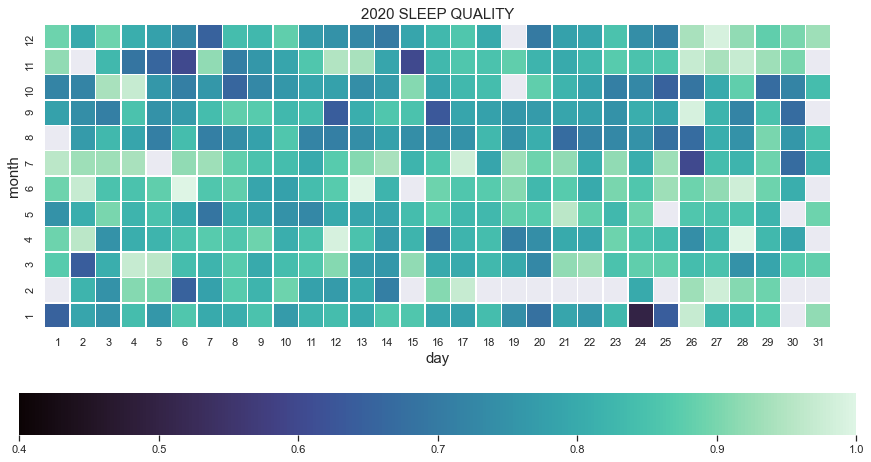

In [181]:
generate_heatmap(sleepqual20, gradient, min_col, max_col, "2020 SLEEP QUALITY", "heatmap_2020qual")

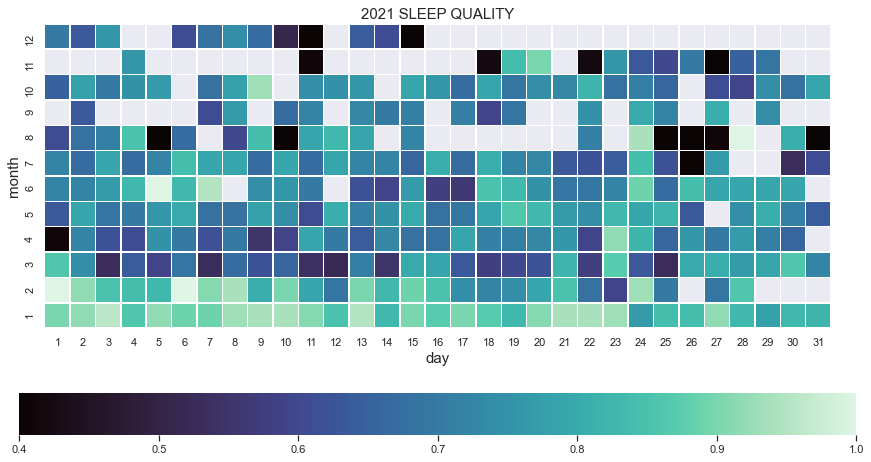

In [182]:
generate_heatmap(sleepqual21, gradient, min_col, max_col, "2021 SLEEP QUALITY", "heatmap_2021qual")

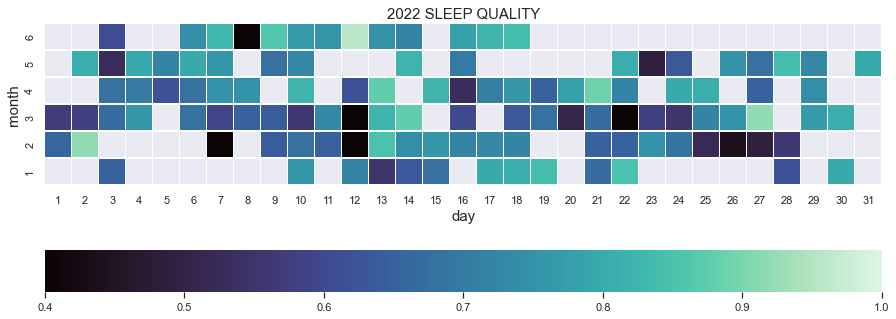

In [183]:
generate_heatmap(sleepqual22, gradient, min_col, max_col, "2022 SLEEP QUALITY", "heatmap_2022qual")